# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://washingtondc.craigslist.org/search/ata?purveyor=owner#search=1~gallery~0~15'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [4]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

listings

[<li class="cl-static-search-result" title="1867 Chatillon’s Improved Spring Balance 24 pound Hanging Milk Scale">
 <a href="https://washingtondc.craigslist.org/nva/atq/d/fairfax-1867-chatillons-improved-spring/7787015932.html">
 <div class="title">1867 Chatillon’s Improved Spring Balance 24 pound Hanging Milk Scale</div>
 <div class="details">
 <div class="price">$60</div>
 <div class="location">
                         Vienna Metro/Pan Am Shopping Center
                     </div>
 </div>
 </a>
 </li>,
 <li class="cl-static-search-result" title="stained glass/bamboo">
 <a href="https://washingtondc.craigslist.org/mld/atq/d/silver-spring-stained-glass-bamboo/7783560783.html">
 <div class="title">stained glass/bamboo</div>
 <div class="details">
 <div class="price">$1,200</div>
 <div class="location">
                         rockville-aspen hill
                     </div>
 </div>
 </a>
 </li>,
 <li class="cl-static-search-result" title="Antique Hobart commercial scale">
 <a href="h

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

## 2. Get your search results of interest and extract data from them, using code similar to what's above.

In [14]:
import re # Regular expressions

#brands = ['ceramic', 'glass','brass','Ceramic','Glass','Brass','Chinese','chinese','Italian','italian',
          #'Fine China','fine china','China','Japan','Victorian','victorian','Antique','antique','Egyptian',
          #'egyptian','Persian','persian','Bowl','bowl', 'cabinet','Cabinet', ]


        #looked at source code it seems some of these would not be the best identifiers because some put two of the same names in one product

brands =  ['ceramic', 'glass', 'brass', 'china', 'fine china', 'japan', 'bronze', 'iron',
    'victorian', 'mid-centuary', 'egyptian',
    'italian', 'egyptian', 'japan',
    'desk', 'cabinet', 'radio', 'lamp', 'bowl']







data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [15]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('antique_listings.csv') # Save data in case of a disaster
df.head()


df

(351, 6)


,title,price,year,link,brand,age
0,1867 chatillon’s improved spring balance 24 po...,60,NaN,https://washingtondc.craigslist.org/nva/atq/d/...,missing,NaN
1,stained glass/bamboo,1200,NaN,https://washingtondc.craigslist.org/mld/atq/d/...,missing,NaN
2,antique hobart commercial scale,125,NaN,https://washingtondc.craigslist.org/mld/atq/d/...,missing,NaN
3,antique national cash register,50,NaN,https://washingtondc.craigslist.org/mld/atq/d/...,missing,NaN
4,"brass jewelry stand or for hand towels, other?",22,NaN,https://washingtondc.craigslist.org/mld/atq/d/...,brass,NaN
...,...,...,...,...,...,...
346,watercolor chinese 1900s,200,1900.0,https://washingtondc.craigslist.org/nva/atq/d/...,missing,125.0
347,drawing seascape original signed,120,NaN,https://washingtondc.craigslist.org/doc/atq/d/...,missing,NaN
348,watch jean cardot,50,NaN,https://washingtondc.craigslist.org/nva/atq/d/...,missing,NaN
349,watercolor sailing nautical signed,150,NaN,https://washingtondc.craigslist.org/nva/atq/d/...,missing,NaN


With the data in and wrangled, we can now do EDA:

count      351.000000
mean       333.287749
std       1351.830395
min          0.000000
25%         40.000000
50%         90.000000
75%        200.000000
max      20000.000000
Name: price, dtype: float64


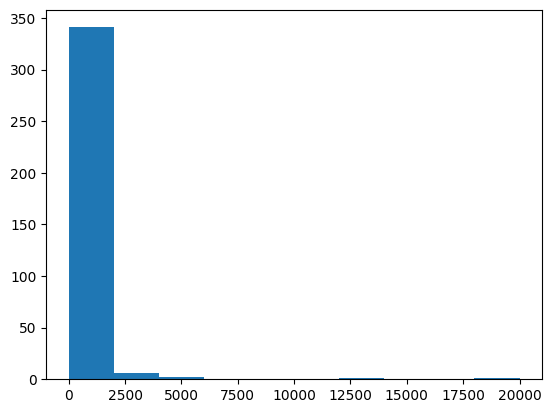

count     46.000000
mean      88.086957
std       26.874049
min        7.000000
25%       75.000000
50%       89.500000
75%      109.250000
max      125.000000
Name: age, dtype: float64


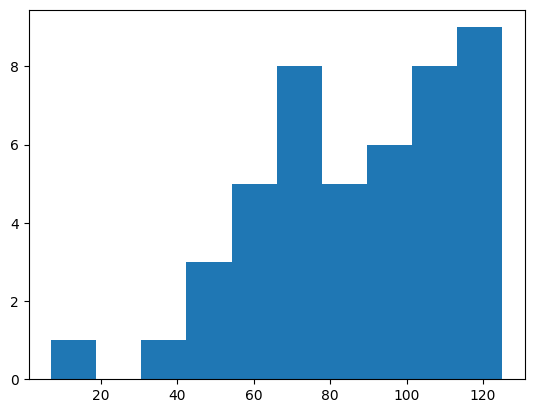

In [16]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [20]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                              \
           count         mean          std     min      25%     50%      75%   
brand                                                                          
bowl         1.0    40.000000          NaN    40.0    40.00    40.0    40.00   
brass       10.0   223.000000   274.237934    22.0    58.50    77.5   321.25   
bronze       5.0   110.000000    26.457513    80.0   100.00   100.0   120.00   
cabinet      3.0  1041.666667  1369.437232    30.0   262.50   495.0  1547.50   
ceramic      1.0    35.000000          NaN    35.0    35.00    35.0    35.00   
china        2.0   250.500000   352.846284     1.0   125.75   250.5   375.25   
desk         5.0   163.000000   132.693255    75.0    80.00   125.0   140.00   
egyptian     2.0  6060.000000  8400.428560   120.0  3090.00  6060.0  9030.00   
glass       16.0    95.312500   115.071988     0.0    22.50    32.5   125.00   
iron        11.0   151.363636   148.274929    15.0    35.00   100.0   187.50   
italian      2.0   612.500000   548.007755   225.0   418.75   612.5   806.25   
japan        1.0   125.000000          NaN   125.0   125.00   125.0   125.00   
lamp         7.0    86.428571    20.959144    60.0    72.50    80.0   100.00   
missing    282.0   314.833333  1312.045798     0.0    36.25    82.5   200.00   
radio        2.0    70.000000    35.355339    45.0    57.50    70.0    82.50   
victorian    1.0  3500.000000          NaN  3500.0  3500.00  3500.0  3500.00   

                    
               max  
brand               
bowl          40.0  
brass        795.0  
bronze       150.0  
cabinet     2600.0  
ceramic       35.0  
china        500.0  
desk         395.0  
egyptian   12000.0  
glass        350.0  
iron         450.0  
italian     1000.0  
japan        125.0  
lamp         120.0  
missing    20000.0  
radio         95.0  
victorian   3500.0

In [21]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

#not a good indicator since age is not represented in this

age                                                      
          count       mean        std   min   25%   50%    75%    max
brand                                                                
bowl        0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
brass       0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
bronze      0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
cabinet     0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
ceramic     0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
china       0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
desk        0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
egyptian    0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
glass       0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
iron        0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
italian     1.0  75.000000        NaN  75.0  75.0  75.0   75.0   75.0
japan       0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN
lamp        1.0  65.000000        NaN  65.0  65.0  65.0   65.0   65.0
missing    43.0  89.465116  27.246973   7.0  75.0  95.0  110.0  125.0
radio       1.0  65.000000        NaN  65.0  65.0  65.0   65.0   65.0
victorian   0.0        NaN        NaN   NaN   NaN   NaN    NaN    NaN

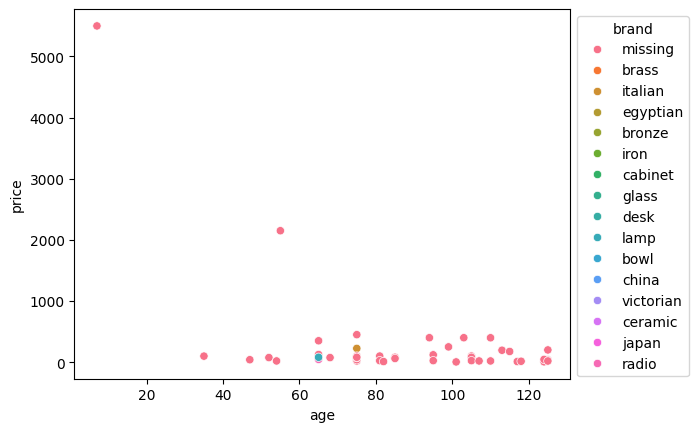

In [22]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   2.010682 -0.327634
log_age    -0.327634  0.224693
           log_price  log_age
log_price    1.00000 -0.48678
log_age     -0.48678  1.00000


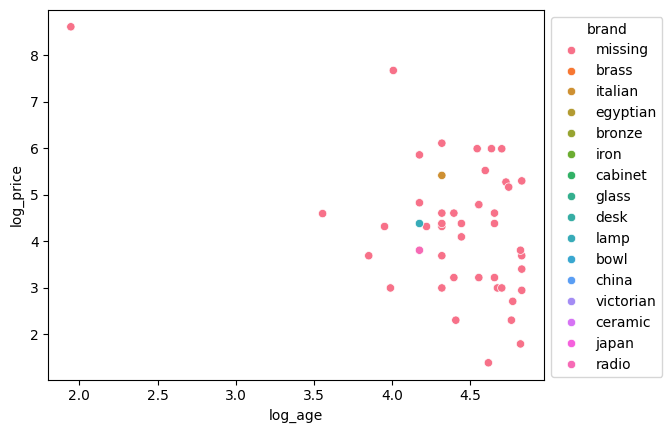

In [23]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

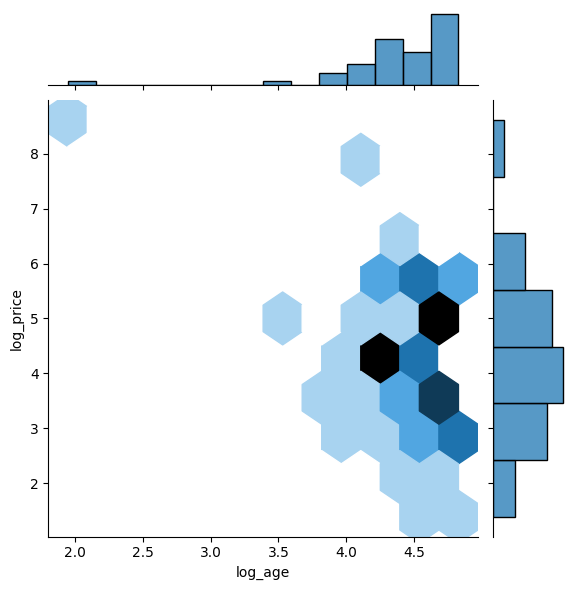

In [24]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.

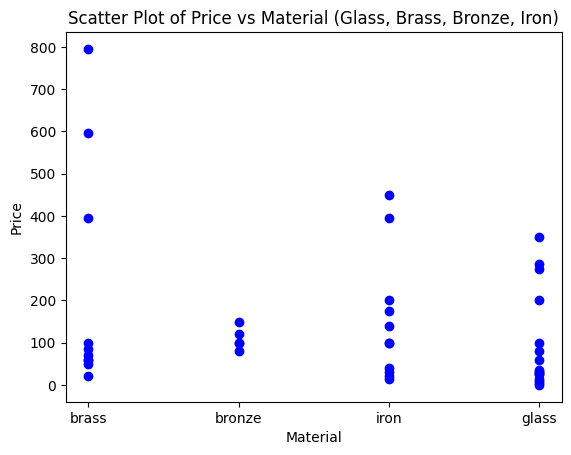

brand
brass     223.000000
bronze    110.000000
glass      95.312500
iron      151.363636
Name: price, dtype: float64


In [33]:
import matplotlib.pyplot as plt


filtered_brands = df[df['brand'].isin(['glass', 'brass', 'bronze', 'iron'])]


plt.scatter(filtered_brands['brand'], filtered_brands['price'], c='blue')

# Add labels and title to the plot
plt.xlabel('Material')
plt.ylabel('Price')
plt.title('Scatter Plot of Price vs Material (Glass, Brass, Bronze, Iron)')

# Show the plot
plt.show()



#ideally it would be better to have age of material on there but since only the missing values seem to include age
#I had to label the x axis by material
#we can see brass has the most expensive antiques, second comes iron. Interesting to see the average price for each




average_price = filtered_brands.groupby('brand')['price'].mean()


print(average_price)


#we can see with the average price it reflects the resultls in the scatter plot

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [53]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        year_post = bsObj.find(class_='attr important').find(class_ = 'valu year').get_text()
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        cylinders = bsObj.find(class_='attr auto_cylinders').find(class_ = 'valu').get_text()
        cylinders = cylinders.replace('\n','')
    except:
        cylinders = 'missing'
    #
    try:
        drivetrain = bsObj.find(class_='attr auto_drivetrain').find(href=True).get_text()
    except:
        drivetrain = 'missing'
    #
    try:
        fuel = bsObj.find(class_='attr auto_fuel_type').find(href = True).get_text()
    except:
        fuel = 'missing'
    #
    try:
        miles = bsObj.find(class_='attr auto_miles').find(class_ = 'valu').get_text()
    except:
        miles = np.nan
    #
    try:
        color = bsObj.find(class_='attr auto_paint').find(href=True).get_text()
    except:
        color='missing'
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    try:
        transmission = bsObj.find(class_='attr auto_transmission').find(href=True).get_text()
    except:
        transmission = 'missing'
    #
    try:
        bodytype = bsObj.find(class_='attr auto_bodytype').find(href=True).get_text()
    except:
        bodytype = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'year_post':year_post,
              'condition':condition,
              'cylinders':cylinders,
              'drivetrain':drivetrain,
              'fuel':fuel,
              'miles':miles,
              'color':color,
              'title':'title',
              'transmission':transmission,
              'bodytype':bodytype,
              'text':text,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [ ]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['miles'] = df['miles'].str.replace(',','')
df['miles'] = pd.to_numeric(df['miles'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_cars_long.csv')

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.